# Imports

In [403]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
from itertools import product
import random
from typing import List, Tuple

from reader import parse_csvs, SimulationResults

# Clean CSV Data Files

In [404]:
from io import TextIOWrapper
import os

for file in [file for file in os.listdir("data") if file.startswith("Attempt")]:
    file_path: str = f"data/{file}"
    f: TextIOWrapper = open(file_path, "r")
    lines: list[str] = f.readlines()
    if lines[0].strip().endswith(";"):
        print(f"Fixing file {file_path}")
        lines[0] = lines[0].strip()[:-1] + "\n"
    f.close()

    f = open(file_path, "w")
    f.writelines(lines)
    f.close()


# Get Data

In [405]:
simulation_results: List[SimulationResults] = parse_csvs()

Started parsing...
Excluding extinct result 109 - 09.05.2024 05-31-28
Excluding extinct result 116 - 09.05.2024 06-04-15
Excluding extinct result 123 - 09.05.2024 06-34-18
Excluding extinct result 134 - 09.05.2024 07-23-55
Excluding extinct result 135 - 09.05.2024 07-26-55
Excluding extinct result 137 - 09.05.2024 07-34-52
Excluding extinct result 142 - 09.05.2024 07-53-57
Excluding extinct result 145 - 09.05.2024 08-05-58
Excluding extinct result 154 - 09.05.2024 08-44-20
Excluding extinct result 155 - 09.05.2024 08-44-46
Excluding extinct result 162 - 09.05.2024 09-14-56
Excluding extinct result 164 - 09.05.2024 09-20-27
Excluding extinct result 168 - 09.05.2024 09-37-14
Excluding extinct result 180 - 09.05.2024 10-29-14
Excluding extinct result 181 - 09.05.2024 10-30-57
Error parsing file Initial settings 182 - 09.05.2024 10-33-28.csv: [Errno 2] No such file or directory: 'c:\\Users\\PC\\Desktop\\studia\\Metody Systemowe i Decyzyjne\\Projekt\\MSiDProject\\data\\Attempt 182 - 09.05.2

# Creating DataFrames

In [406]:
initial_parameters = DataFrame([result.parameters.iloc[0] for result in simulation_results])
results = DataFrame([result.get_last_history() for result in simulation_results])

# Introductory analysis

In [407]:
def correlation_matrix(df: pd.DataFrame) -> None:
    """
    Generate a correlation matrix heatmap for a given DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame for which the correlation matrix is to be generated.

    Returns:
    - None
    """
    plt.figure(figsize=(12,8))
    sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
    plt.show()
    
def correlation_column(df: pd.DataFrame, column: str) -> None:
    """
    Generates a heatmap showing the correlation between the specified column and all other columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column to calculate the correlation with.

    Returns:
    None
    """
    plt.figure(figsize=(12,8))
    corr: DataFrame = df.corr()[[column]].drop(column)
    sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')
    plt.show()

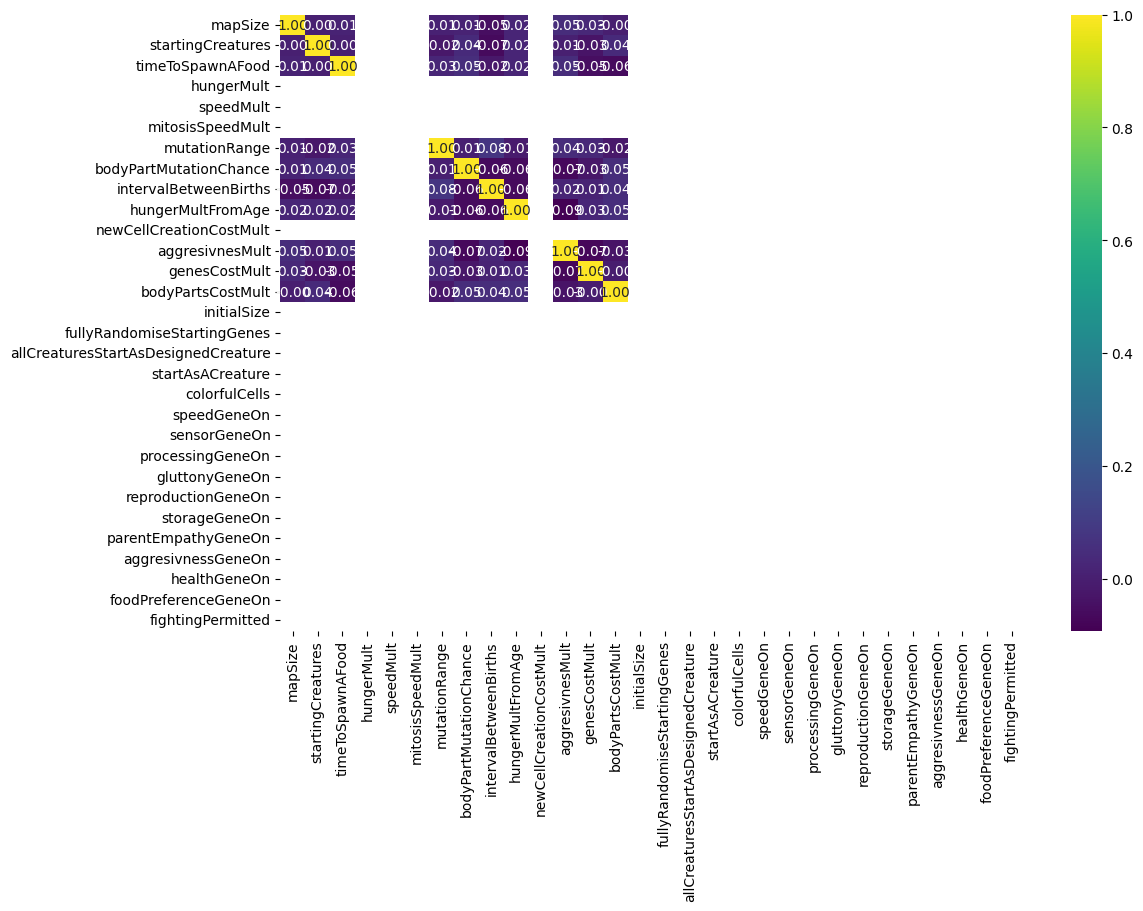

In [408]:
correlation_matrix(initial_parameters)

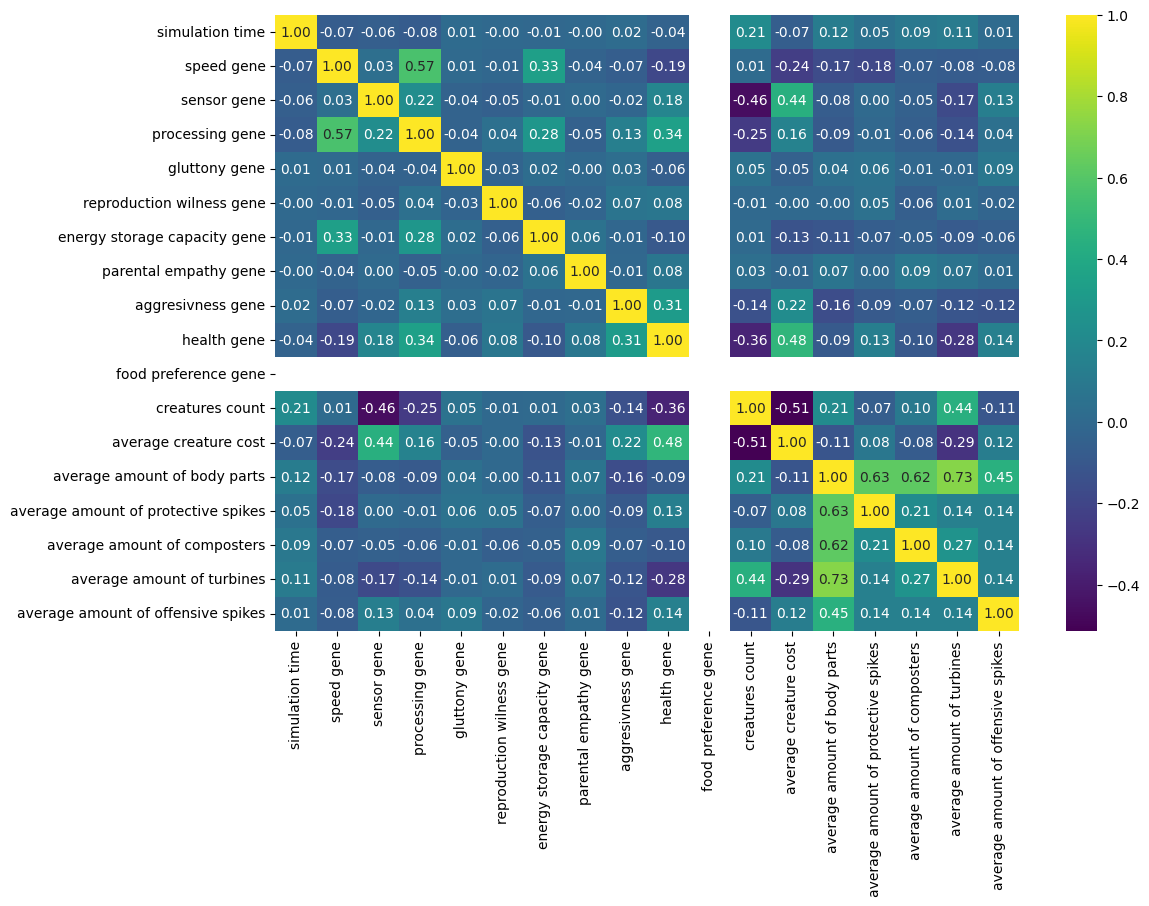

In [409]:
correlation_matrix(results)

It is clear from the data, that many columns can be dropped.

# Cleaning Data

In [410]:
initial_parameters: DataFrame = initial_parameters.drop(
    columns=[
        "hungerMult",
        "speedMult",
        "mitosisSpeedMult",
        "newCellCreationCostMult", 
        "initialSize", 
        "fullyRandomiseStartingGenes", 
        "allCreaturesStartAsDesignedCreature", 
        "startAsACreature",
        "colorfulCells", 
        "speedGeneOn", 
        "sensorGeneOn", 
        "processingGeneOn", 
        "gluttonyGeneOn",
        "reproductionGeneOn", 
        "storageGeneOn", 
        "parentEmpathyGeneOn", 
        "aggresivnessGeneOn", 
        "healthGeneOn", 
        "foodPreferenceGeneOn", 
        "fightingPermitted"
        ]
    ).dropna()

results: DataFrame = results.drop(
    columns=[        
        "simulation time", 
        "food preference gene"
        ]
    )

results = results.loc[:, ~results.columns.str.contains('^Unnamed')]

print()

Simulation time was also dropped, because only simulations, that stopped ~ 4500 simulation seconds (the maximum time), are analysed

In [411]:
print(results.iloc[0])

speed gene                              0.991227
sensor gene                             0.416732
processing gene                         0.814775
gluttony gene                           0.573346
reproduction wilness gene               0.307748
energy storage capacity gene            0.733310
parental empathy gene                   0.345123
aggresivness gene                       0.866806
health gene                             0.861556
creatures count                        18.000000
average creature cost                   1.545005
average amount of body parts            0.000000
average amount of protective spikes     0.000000
average amount of composters            0.000000
average amount of turbines              0.000000
average amount of offensive spikes      0.000000
Name: 9, dtype: float64


In [412]:
print(initial_parameters.iloc[0])

mapSize                   23.761980
startingCreatures         15.000000
timeToSpawnAFood           4.529128
mutationRange              0.383709
bodyPartMutationChance     0.005873
intervalBetweenBirths     64.644820
hungerMultFromAge          0.003437
aggresivnesMult            1.202730
genesCostMult              0.254597
bodyPartsCostMult          0.791882
Name: 0, dtype: float64


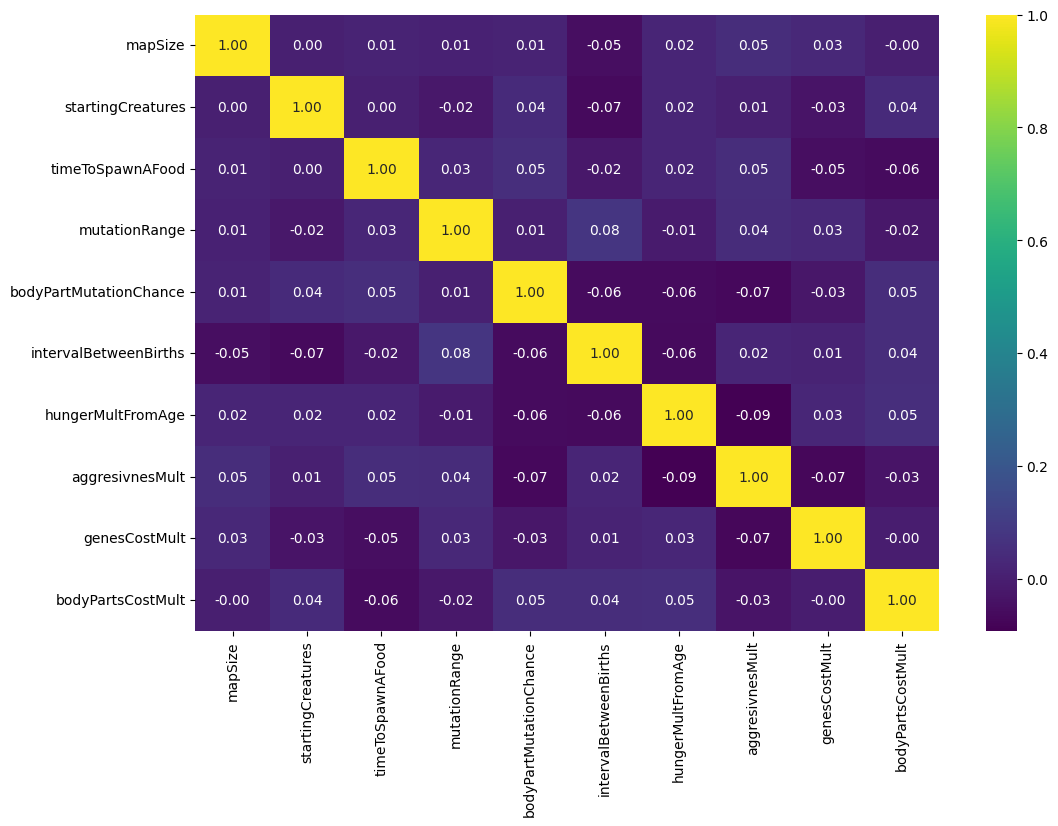

In [413]:
correlation_matrix(initial_parameters)

Correlation of one initial parameter to another is close to zero, as expected. <br>
The initial parameters were generated upon creating the simulation with the help of this custom random power function:

```csharp

float GenerateRandomValue(float min, float max, float mean)
{
    float meanWeight = meanWeightMultiplier * Random.value;

    float x = (Random.value + .5f * meanWeight) / (1 + meanWeight);

    float value = CustomPowerFunction(x, min, max, mean);

    return value;
}

float CustomPowerFunction(float x, float min, float max, float mean)
{
    float meanInterpolated = (mean - min) / (max - min);

    return Mathf.Pow(x, Mathf.Log(meanInterpolated, 0.5f)) * (max - min) + min;
}

46.75486339541208


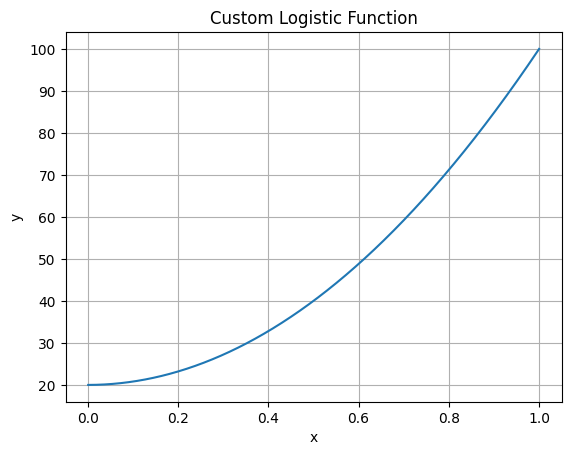

In [414]:
import numpy as np
import math
import matplotlib.pyplot as plt

def custom_logistic(x, mn, mx, mean):    
    m_inter = (mean-mn)/(mx-mn)
       
    return x**math.log(m_inter, 0.5) * (mx-mn) + mn

mn = 20
mx = 100
mean = 40

mnx: float = (mean - mn) / (mx - mn)

x_values = np.linspace(0.001, 1, 1000)
y_values = custom_logistic(x_values, mn, mx, mean)

print(sum(custom_logistic(random.uniform(0., 1.), mn, mx, mean) for _ in range(100000)) / 100000)

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom Logistic Function')
plt.grid(True)
plt.show()

The goal was to create a function, that 50% of y values generated are small then the picked "mean", and another 50% above it. <br>
The average != mean, and for this example, it's closer to 46.6. Still, this is a decent way to generate random initial parameters non-linearly.

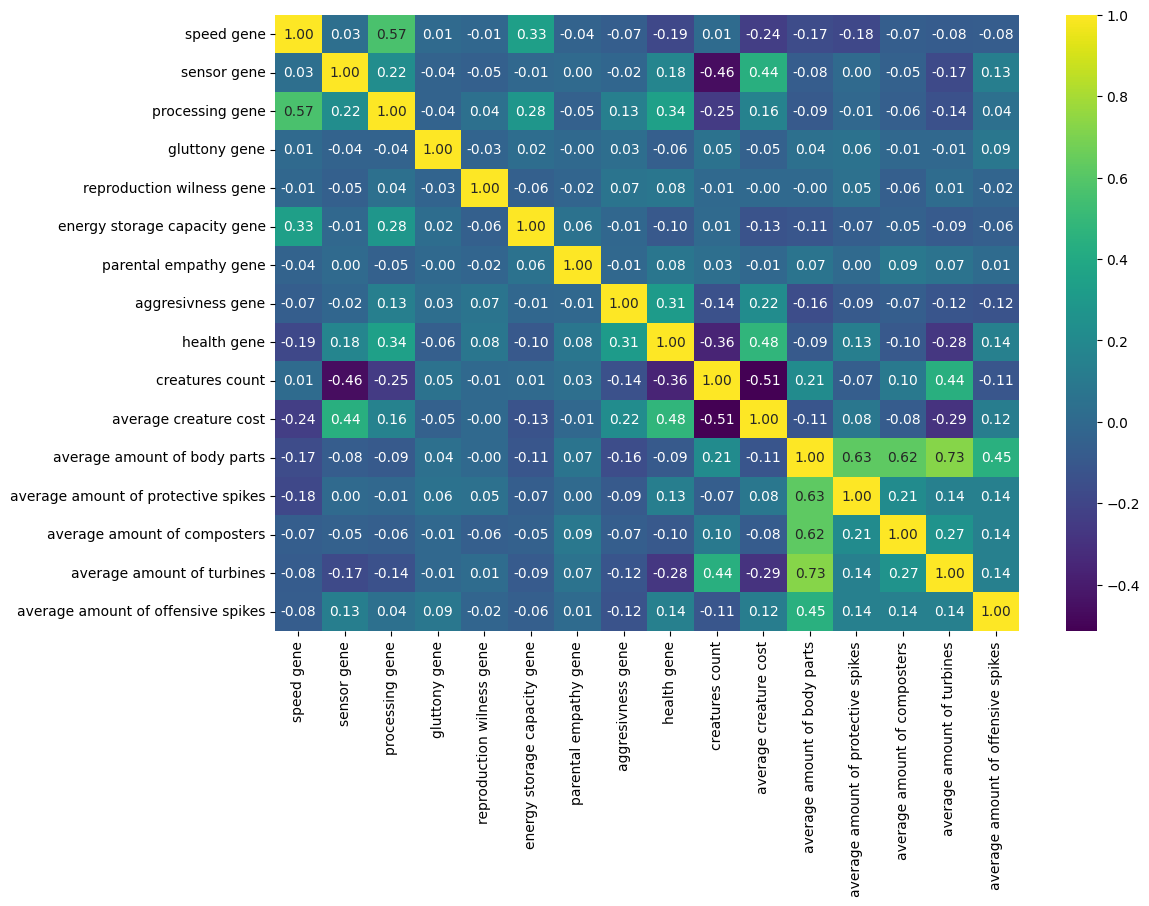

In [415]:
correlation_matrix(results)

Many interesting correlations can be observed with just this correlation matrix. <br><br>
Some of them are obvious - average amount of body parts is based on the average amounts of other body parts. <br><br>
There are strong negative correlations between creatures count and average creature cost. Also between creatures count and health gene. With more creatures, it's less advantegous to have a better developed sensor gene. <br><br>
A pretty interesting strong correlation is between creature count and average amount of turbines. It seems like with more creatures, it's important to get to food before others. Than again, the same correlation is not observed between creature count and speed gene. There could be many explanations, including an unintentional bug in game - data was collected with simulation speed of 16, which is quite large. Because of that, creatures with high speed can "miss" food, because they have less frames to adjust their movement. Turbines greatly increase turning speed, while the speed gene doesn't.

# Estimating results from initial parameters

In [416]:
def estimate(model, initial_parameters, results):
    regressed = model.fit(initial_parameters, results)
    return regressed
        
for column in results.columns:
    analyzed_column = results[column]
        
    x_train, x_test, y_train, y_test = train_test_split(initial_parameters, analyzed_column, test_size=0.2)
        
    reg: LinearRegression = estimate(LinearRegression(), x_train, y_train)
    
    print(f"{column} : {reg.score(initial_parameters, analyzed_column)}")

speed gene : 0.29710037455430083
sensor gene : 0.27070624420383194
processing gene : 0.5712904777039708
gluttony gene : 0.018544668751824478
reproduction wilness gene : 0.0013551048423244838
energy storage capacity gene : 0.17393049117792359
parental empathy gene : 0.05007650464858637
aggresivness gene : 0.07118907098732608
health gene : 0.44923345887857835
creatures count : 0.6876173416984859
average creature cost : 0.42503240636337225
average amount of body parts : 0.49244508417605404
average amount of protective spikes : 0.22787314887247956
average amount of composters : 0.2164676324067346
average amount of turbines : 0.360610470728551
average amount of offensive spikes : 0.15271005506385227


Some of the scores are 

# Estimating Average Creature Cost from Initial Parameters

This report will focus on trying to estimate average creature cost, first from just the initial parameters, and later from the other results too. 

In [417]:
ANALYZED = "average creature cost"

analyzed_column = results[ANALYZED]
print(analyzed_column)

9     1.545005
9     8.851233
9     2.562723
9     1.353786
9    44.179050
       ...    
9     0.839489
9     1.214765
9    22.911050
9     0.278829
9     1.489179
Name: average creature cost, Length: 546, dtype: float64


In [418]:

df_1: DataFrame = initial_parameters.copy()

df_1[ANALYZED] = list(analyzed_column)

print(df_1.head())

    mapSize  startingCreatures  timeToSpawnAFood  mutationRange  \
0  23.76198               15.0          4.529128       0.383709   
0  24.69442               18.0          2.010151       0.286781   
0  44.97563               15.0          6.406969       0.767422   
0  38.97704               41.0          3.277926       0.022458   
0  25.28580               28.0          3.036764       0.092825   

   bodyPartMutationChance  intervalBetweenBirths  hungerMultFromAge  \
0                0.005873               64.64482           0.003437   
0                0.013992               10.22332           0.005131   
0                0.191583               41.19628           0.004297   
0                0.012400               68.63533           0.005164   
0                0.025843               38.36862           0.001853   

   aggresivnesMult  genesCostMult  bodyPartsCostMult  average creature cost  
0         1.202730       0.254597           0.791882               1.545005  
0         1.10

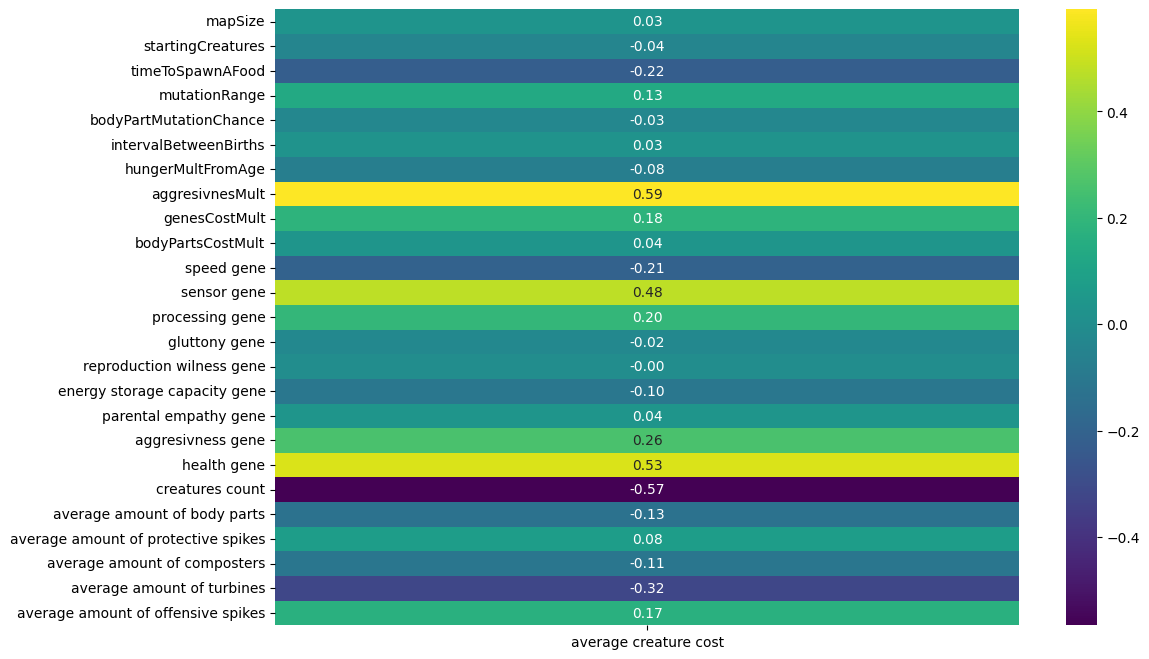

In [419]:
correlation_column(df, ANALYZED)

Only three parameters will be kept: aggresivnesMult, timeToSpawnAFood and genesCostMult.

In [420]:
df_1 = df_1.loc[
    :,
    df_1.columns.intersection(
        [
            "aggresivnesMult",
            "timeToSpawnAFood",
            "genesCostMult",
            "average creature cost",
        ]
    ),
]


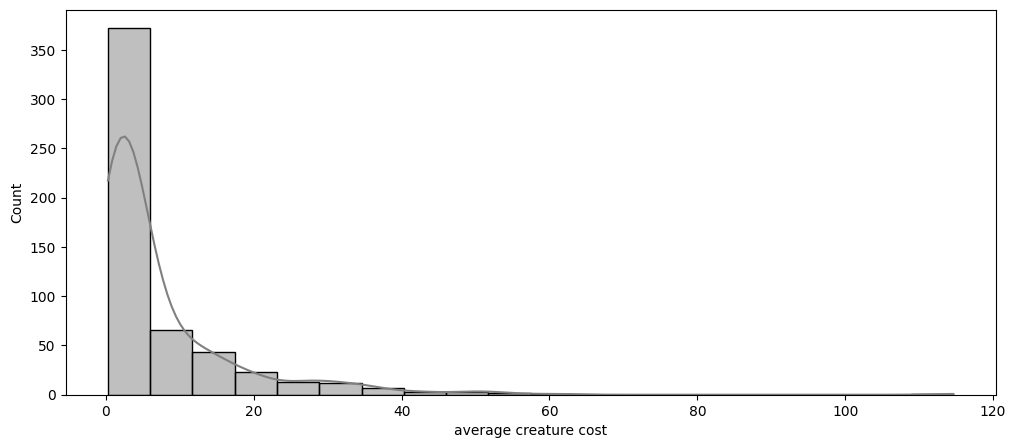

In [421]:
plt.figure(figsize=(12,5))
sns.histplot(analyzed_column, bins=20, kde=True, color='gray')
plt.show()

The vast majority of simulations have their creatures cost, on average, less than 50. Outliers will be removed.

# Removing Outliers

In [422]:
df_1 = df_1[df_1[ANALYZED] <= 50]
print(df_1.head())

   timeToSpawnAFood  aggresivnesMult  genesCostMult  average creature cost
0          4.529128         1.202730       0.254597               1.545005
0          2.010151         1.104876       0.536166               8.851233
0          6.406969         0.084410       2.139121               2.562723
0          3.277926         0.412461       0.613999               1.353786
0          3.036764         1.791308       0.722118              44.179050


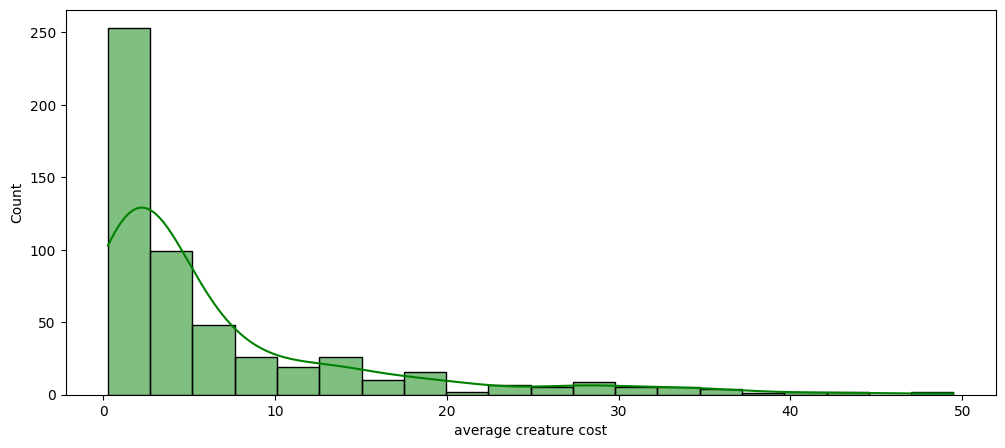

In [423]:
plt.figure(figsize=(12,5))
sns.histplot(df_1[ANALYZED],bins=20,kde=True,color='green')
plt.show()

# Linear Regression

In [424]:
def regress(x, y) -> LinearRegression:    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    reg: LinearRegression = estimate(
        LinearRegression(), x_train, y_train
    )
    print(f"Regression coefficients: {reg.coef_}")
    print(
        f"Regression score on test data: {reg.score(x_test, y_test)}"
    )
    print(f"Regression score on train data: {reg.score(x_train, y_train)}")
    print(f"Regression score on full data: {reg.score(x, y)}")
    
    return reg


In [425]:
x = df_1.drop(columns=[ANALYZED])
y = df_1[ANALYZED]

regress(x, y)

print()

Regression coefficients: [-0.76196925  6.77274127  2.25938051]
Regression score on test data: 0.47105514644300595
Regression score on train data: 0.4561121917373172
Regression score on full data: 0.4601094391234941



# Scatter Plots

In [426]:
def visualise_scatter(x, y, data, show_reg=True, xlim=None, ylim=None) -> None:
    plt.figure(figsize=(12,5))
    sns.scatterplot(data=data,x=x,y=y,hue=y,palette='RdYlGn')
    if show_reg:
        sns.regplot(data=data,x=x,y=y,scatter=False,truncate=True,order=3,color='0.2')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.show()

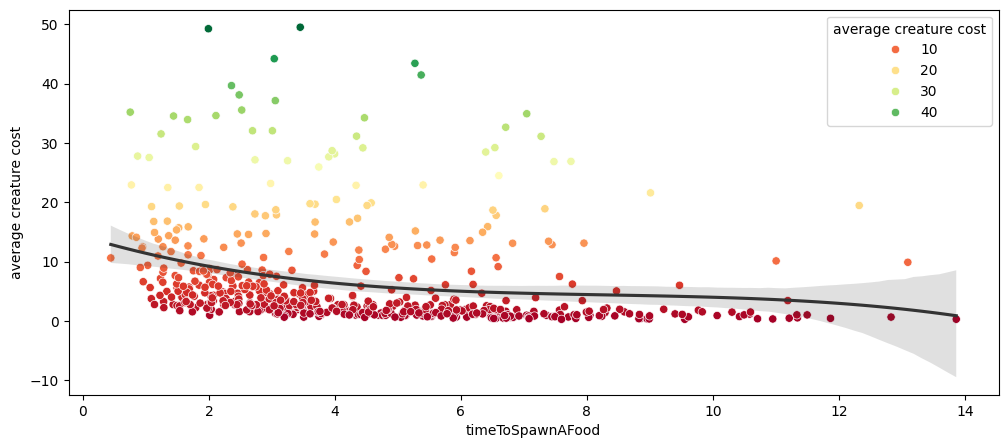

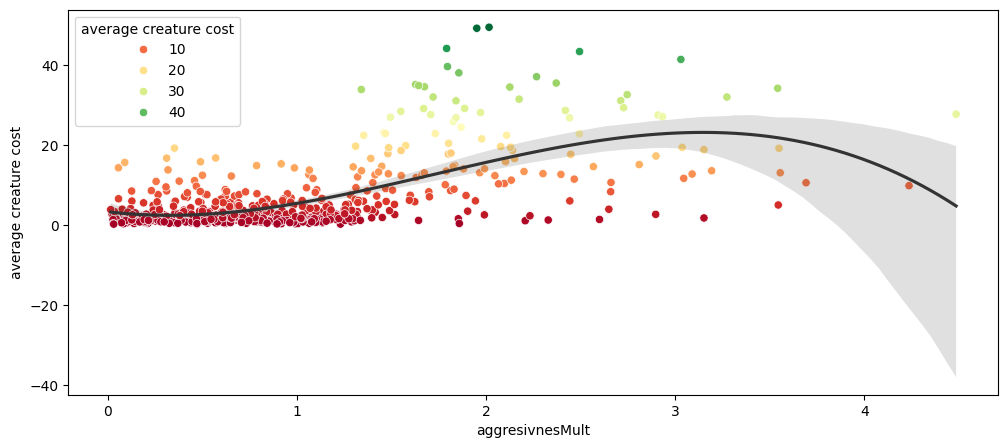

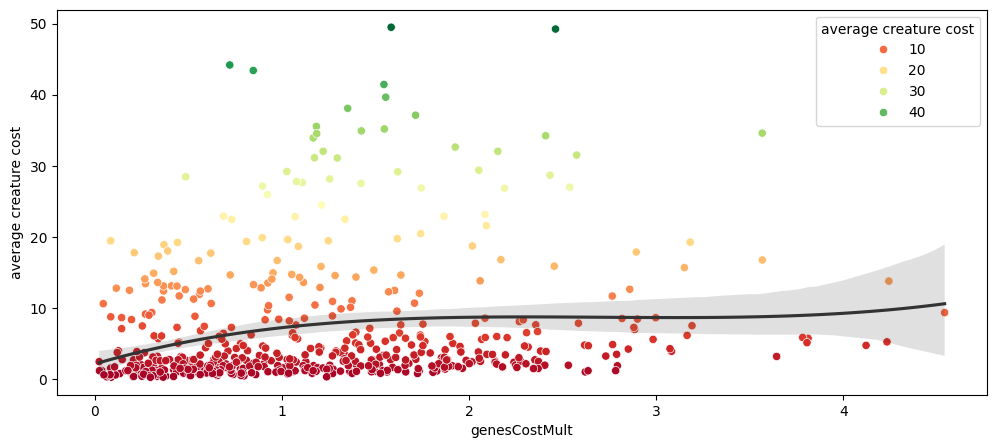

In [427]:
for i in df_1.columns[:-1]:
    visualise_scatter(
        x=i,
        y=ANALYZED,
        data=df_1,
        show_reg=True
        )

The results are underwhelming - the linear regression score is around 0.45. This means, that with this model, it is not possible to accurately estimate average creature cost from just the initial parameters.

# Estimating Average Creature Cost from Initial Parameters and Results

Perhaps regression based on the simulation result data and the simulation's initial parameters will be stronger.

In [428]:
df_2: DataFrame = initial_parameters.copy()

df_2 = df_2.reset_index(drop=True)
results: DataFrame = results.reset_index(drop=True)
df_2 = pd.concat([df_2, results], axis=1)
print(df_2.head())

    mapSize  startingCreatures  timeToSpawnAFood  mutationRange  \
0  23.76198               15.0          4.529128       0.383709   
1  24.69442               18.0          2.010151       0.286781   
2  44.97563               15.0          6.406969       0.767422   
3  38.97704               41.0          3.277926       0.022458   
4  25.28580               28.0          3.036764       0.092825   

   bodyPartMutationChance  intervalBetweenBirths  hungerMultFromAge  \
0                0.005873               64.64482           0.003437   
1                0.013992               10.22332           0.005131   
2                0.191583               41.19628           0.004297   
3                0.012400               68.63533           0.005164   
4                0.025843               38.36862           0.001853   

   aggresivnesMult  genesCostMult  bodyPartsCostMult  ...  \
0         1.202730       0.254597           0.791882  ...   
1         1.104876       0.536166           0.89

# Cleaning Data

In [429]:
df_2 = df_2[df_2[ANALYZED] <= 50]
print(df_2.head())

    mapSize  startingCreatures  timeToSpawnAFood  mutationRange  \
0  23.76198               15.0          4.529128       0.383709   
1  24.69442               18.0          2.010151       0.286781   
2  44.97563               15.0          6.406969       0.767422   
3  38.97704               41.0          3.277926       0.022458   
4  25.28580               28.0          3.036764       0.092825   

   bodyPartMutationChance  intervalBetweenBirths  hungerMultFromAge  \
0                0.005873               64.64482           0.003437   
1                0.013992               10.22332           0.005131   
2                0.191583               41.19628           0.004297   
3                0.012400               68.63533           0.005164   
4                0.025843               38.36862           0.001853   

   aggresivnesMult  genesCostMult  bodyPartsCostMult  ...  \
0         1.202730       0.254597           0.791882  ...   
1         1.104876       0.536166           0.89

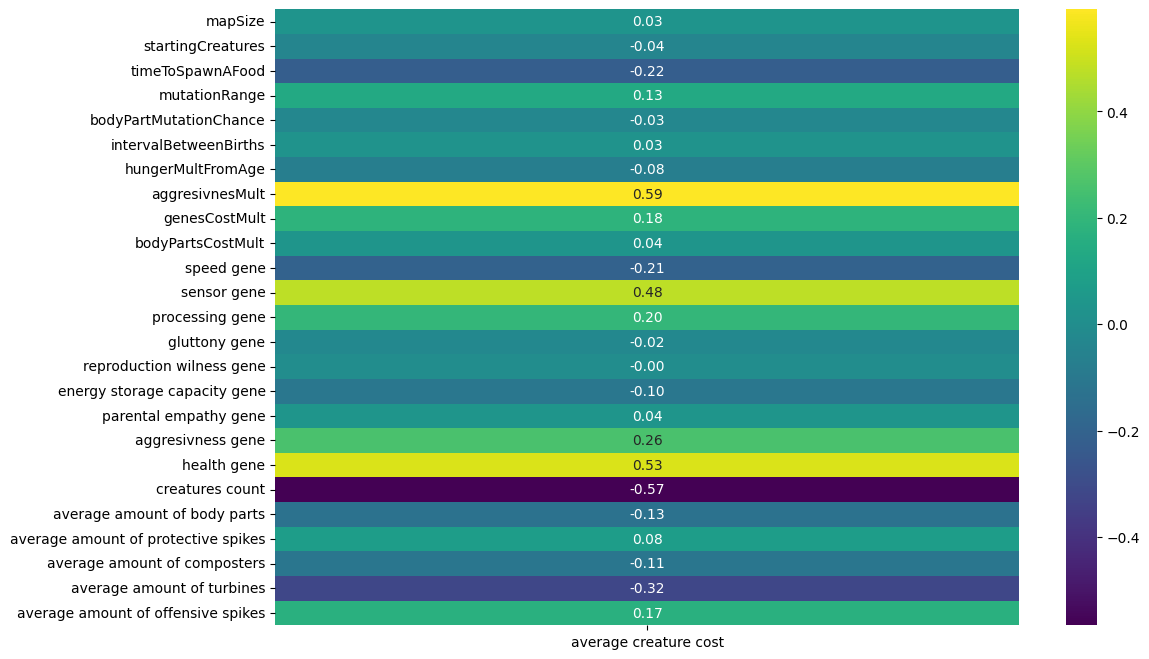

In [430]:
correlation_column(df_2, ANALYZED)

The correlations' strength seems to be more promising now. Let's keep the previously selected initial parameters (aggresivnesMult, timeToSpawnAFood and genesCostMult), but also add these parameters: speed gene, sensor gene, processing gene, aggresivness gene, health gene, creature count, average amount of turbines and average amount of offensive spikes.

In [431]:
df_2 = df_2.loc[
    :,
    df_2.columns.intersection(
        [
            "aggresivnesMult",
            "timeToSpawnAFood",
            "genesCostMult",
            "speed gene",
            "sensor gene",
            "processing gene",
            "aggresivness gene",
            "health gene",
            "creatures count",
            "average amount of turbines",
            "average amount of offensive spikes",
            "average creature cost"
        ]
    ),
]

In [432]:
print(df_2.columns)

Index(['timeToSpawnAFood', 'aggresivnesMult', 'genesCostMult', 'speed gene',
       'sensor gene', 'processing gene', 'aggresivness gene', 'health gene',
       'creatures count', 'average creature cost',
       'average amount of turbines', 'average amount of offensive spikes'],
      dtype='object')


In [433]:
df_2 = df_2[df_2["creatures count"] <= 100]

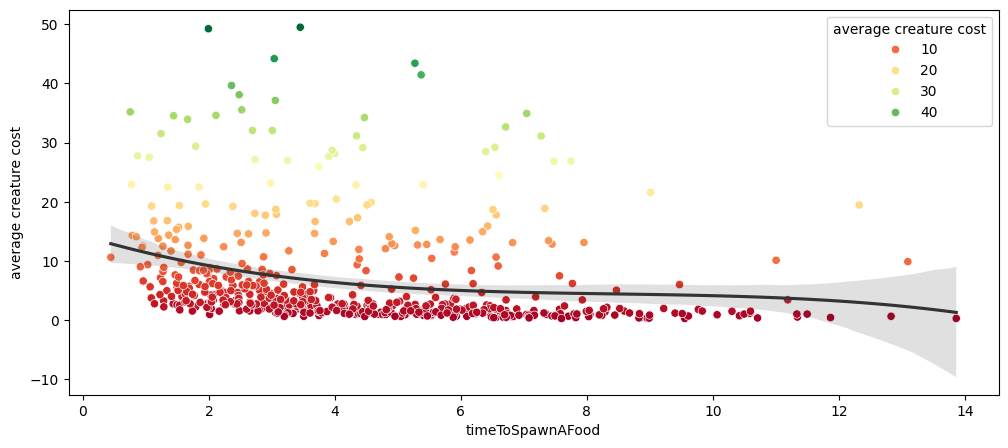

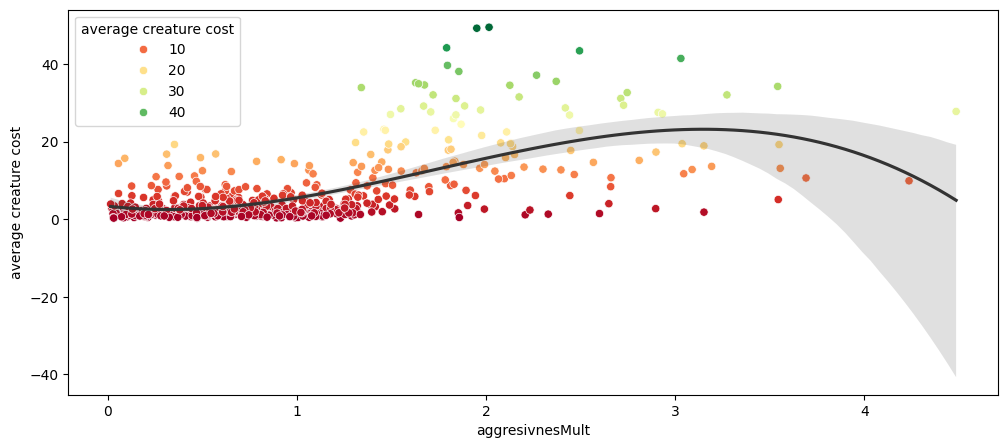

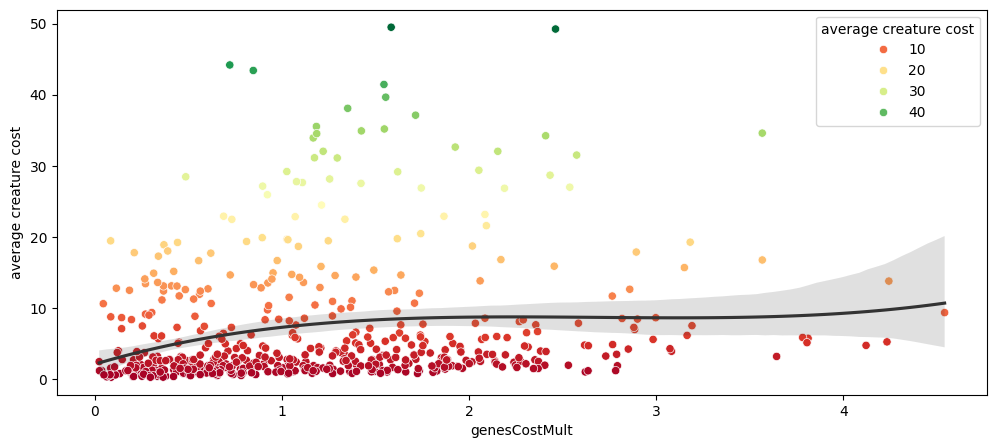

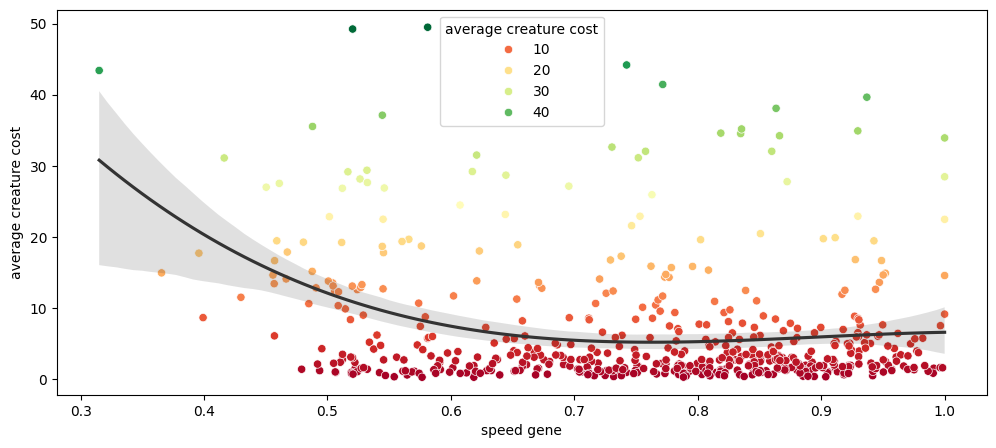

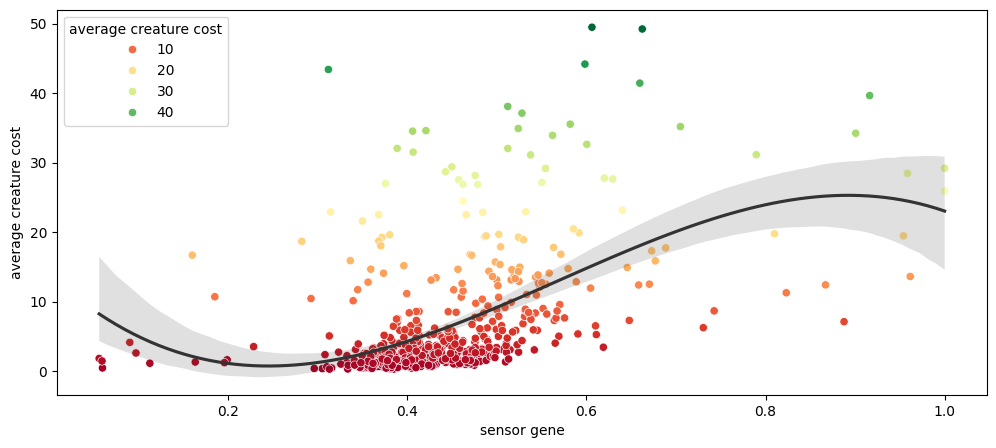

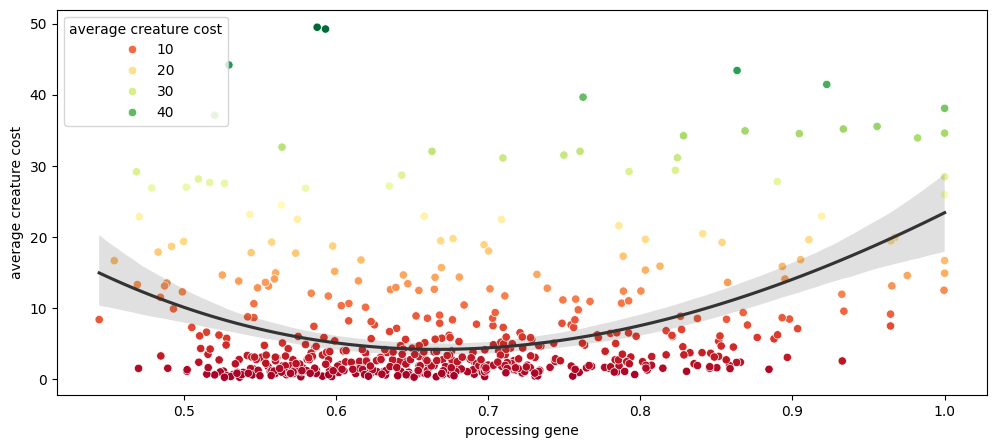

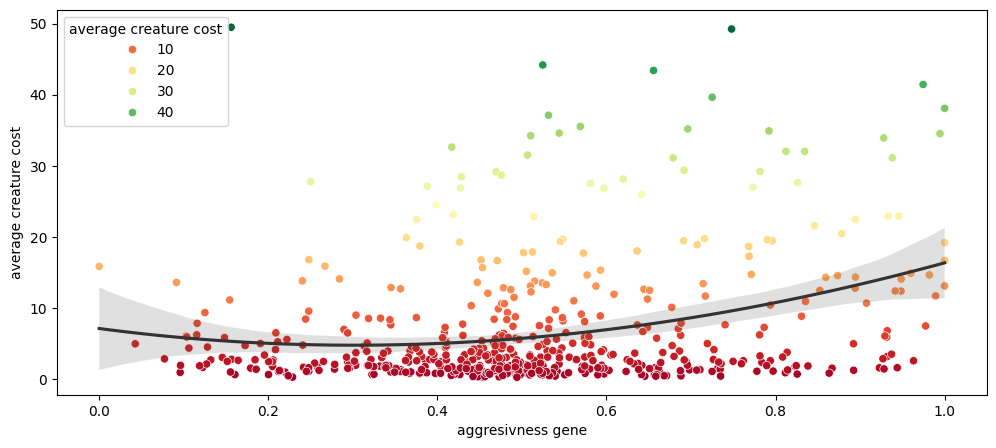

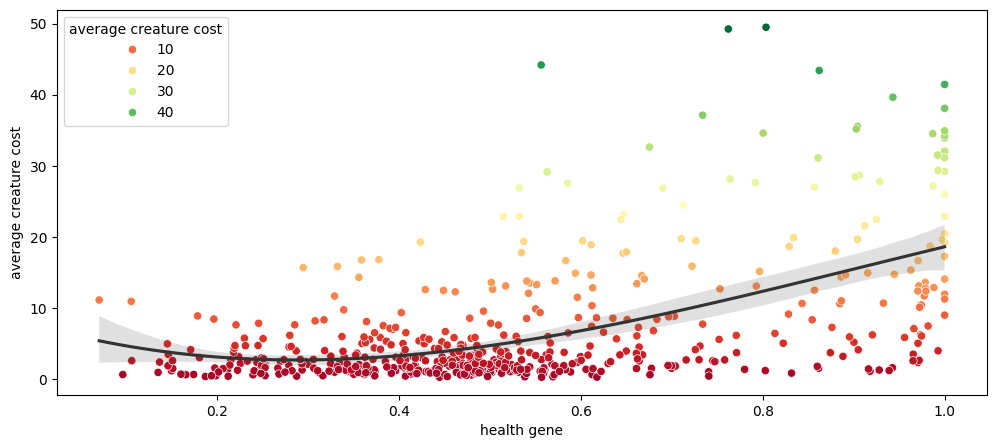

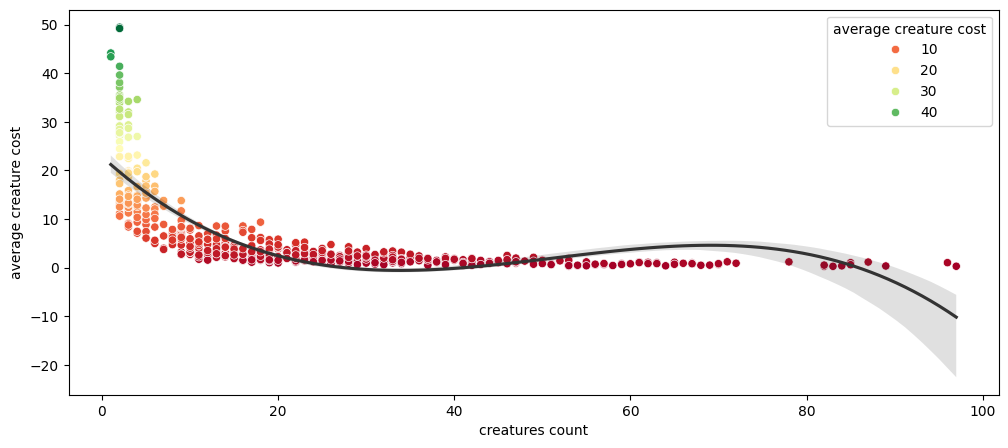

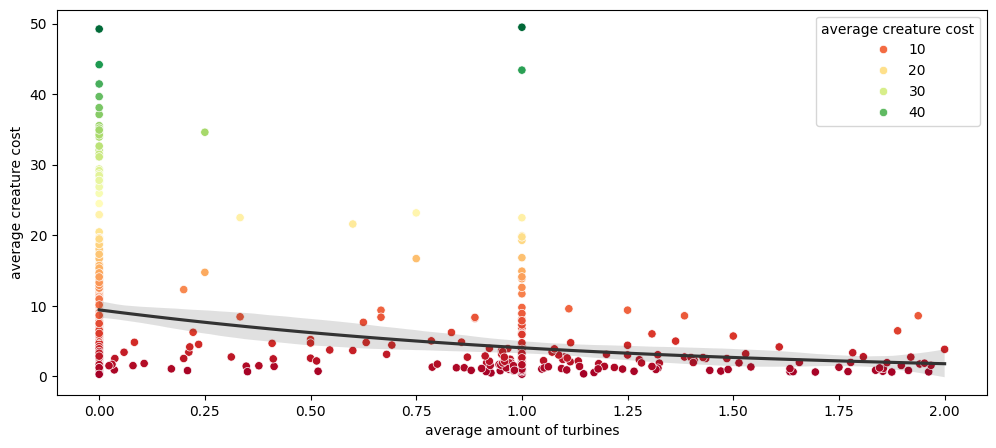

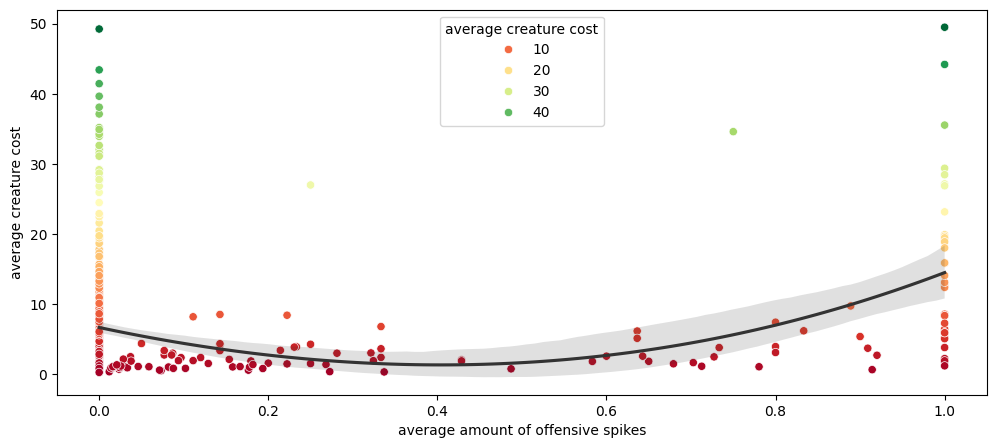

In [434]:
for i in df_2.drop(columns=[ANALYZED]).columns:
    visualise_scatter(
        x=i,
        y=ANALYZED,
        data=df_2,
        show_reg=True
        )

In [435]:
x = df_2.drop(columns=[ANALYZED])
y = df_2[ANALYZED]

scaler = StandardScaler()
x = scaler.fit_transform(x, y)

reg: LinearRegression = regress(x, y)

Regression coefficients: [-0.56252095  2.71748217  2.08058052 -1.38702564  2.67276175  0.32359652
  0.92566344  1.22180591 -1.23875225 -0.25935139  0.47127592]
Regression score on test data: 0.5522972846501226
Regression score on train data: 0.6340759999269991
Regression score on full data: 0.6208160211475359


It is now clear that estimation with the result data yields better, but far from perfect regression score. Perhaps the LinearRegression model isn't the right tool for estimating this data?

# Comparing Different Models

In [436]:
X = df_1.drop(columns=[ANALYZED])
y = df_1[ANALYZED]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<Axes: >

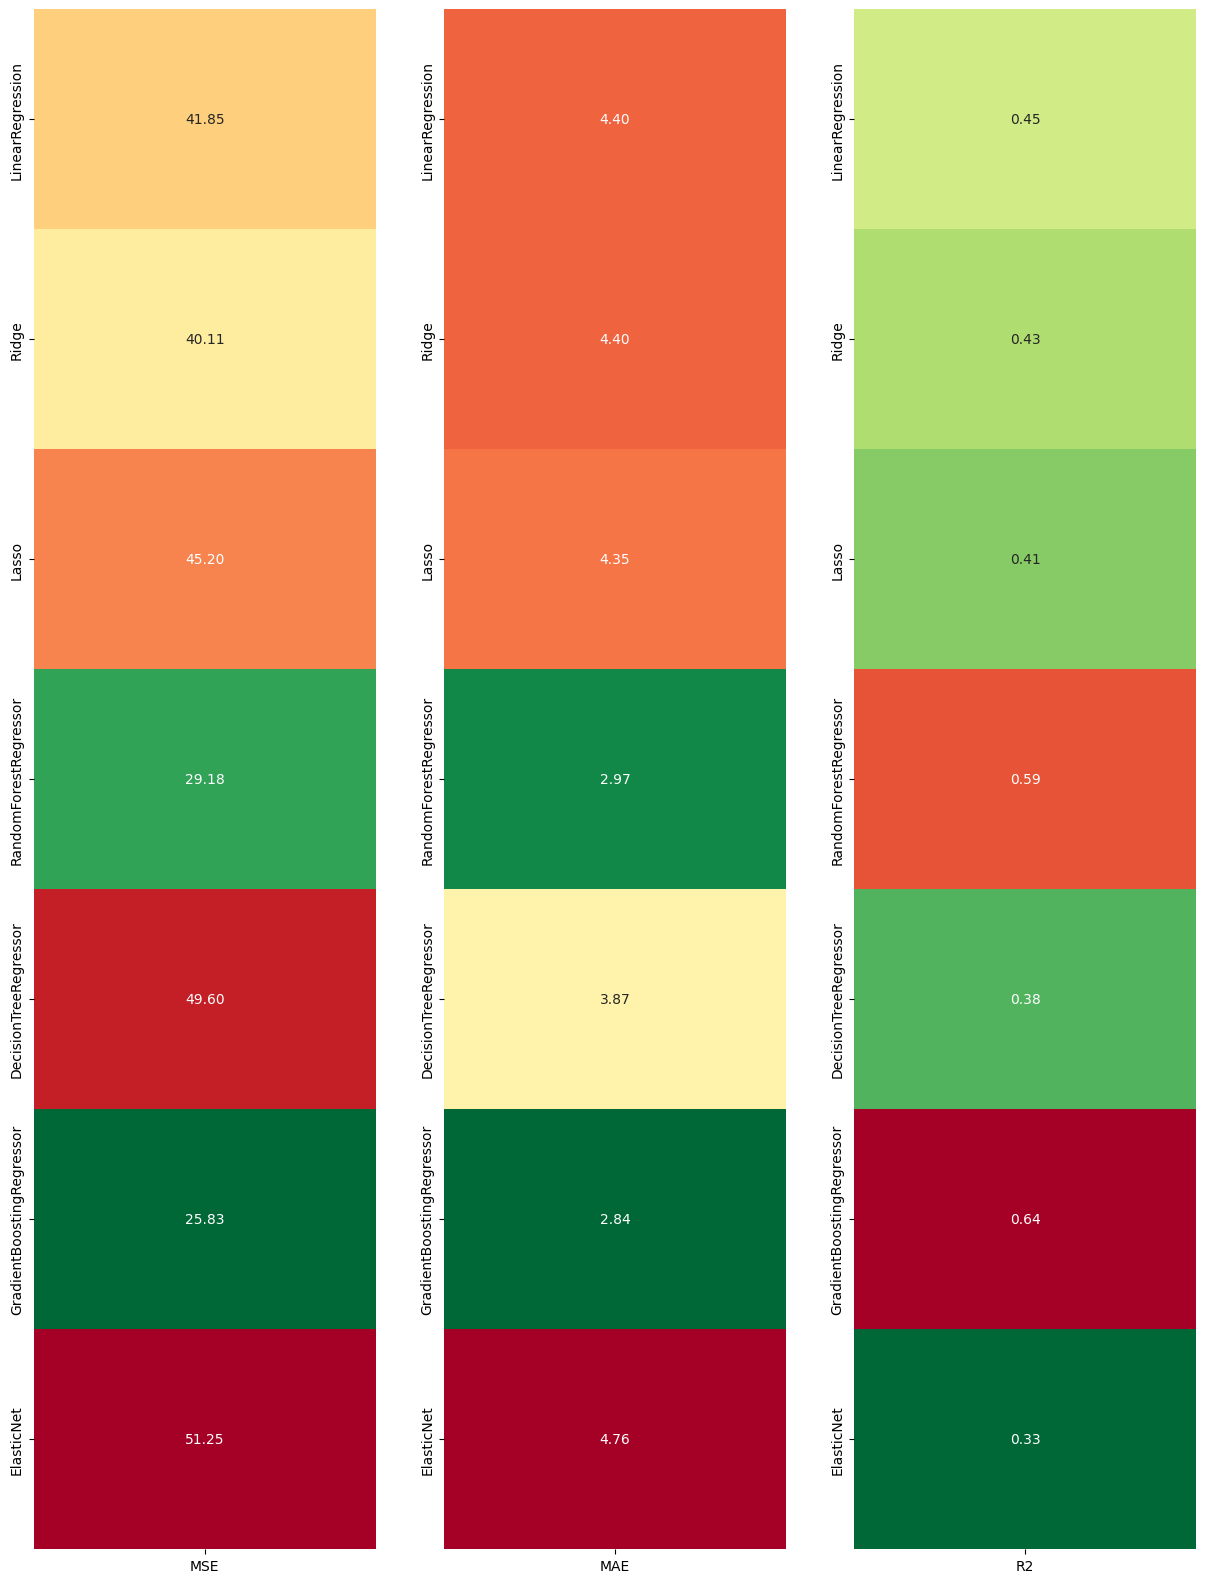

In [437]:
def test_models(x, y, models, repetitions=25) -> dict:
    """
    Test multiple models using cross-validation and return the average performance metrics.

    Parameters:
    x (array-like): The input features.
    y (array-like): The target variable.
    models (list): A list of machine learning models to test.
    repetitions (int, optional): The number of repetitions for cross-validation. Default is 25.

    Returns:
    dict: A dictionary containing the average performance metrics for each model.

    """
    results = {}
    for _ in range(repetitions):
        for model,name  in zip(models,[model.__class__.__name__ for model in models]):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            for metric, metricname in zip([mean_squared_error,mean_absolute_error,r2_score],['MSE','MAE','R2']):
                if name not in results:
                    results[name] = {}
                if metricname not in results[name]:
                    results[name][metricname] = []
                results[name][metricname].append(metric(y_test,y_pred))
                
    for key in results:
        for metric in results[key]:
            results[key][metric] = np.mean(results[key][metric])
    return results

results = test_models(X,y,[LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor(),ElasticNet()],repetitions=25)
results_df = pd.DataFrame(results).T
fig, ax= plt.subplots(ncols=3,figsize=(15,20))
sns.heatmap(results_df[['MSE']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[0],cbar=False)
sns.heatmap(results_df[['MAE']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[1],cbar=False)
sns.heatmap(results_df[['R2']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[2],cbar=False)

Three models will be compared: LinearRegression, RandomForestRegressor and GradientBoostingRegressor.

In [438]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [439]:
y_pred_lr = lr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)

def evaluate_model(y_true, y_pred, model_name) -> dict[str, float]:
    mse: float = mean_squared_error(y_true, y_pred)
    mae: float = mean_absolute_error(y_true, y_pred)
    r2: float  = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}")
    
    return {"mse": mse, "mae": mae, "r2": r2}

lr_scores: dict[str, float] = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rf_scores: dict[str, float] = evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
gbr_scores: dict[str, float] = evaluate_model(y_test, y_pred_gbr, "Gradient Boosting Regressor")

scores = pd.DataFrame([lr_scores, rf_scores, gbr_scores], index=["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor"])

Linear Regression - MSE: 54.9470391581317, MAE: 5.416832807056178, R2: 0.43753363699797543
Random Forest Regressor - MSE: 29.696239045693613, MAE: 3.184478152183485, R2: 0.6960139103619367
Gradient Boosting Regressor - MSE: 31.65768028493922, MAE: 3.3330624404575455, R2: 0.6759355815386922


<Axes: >

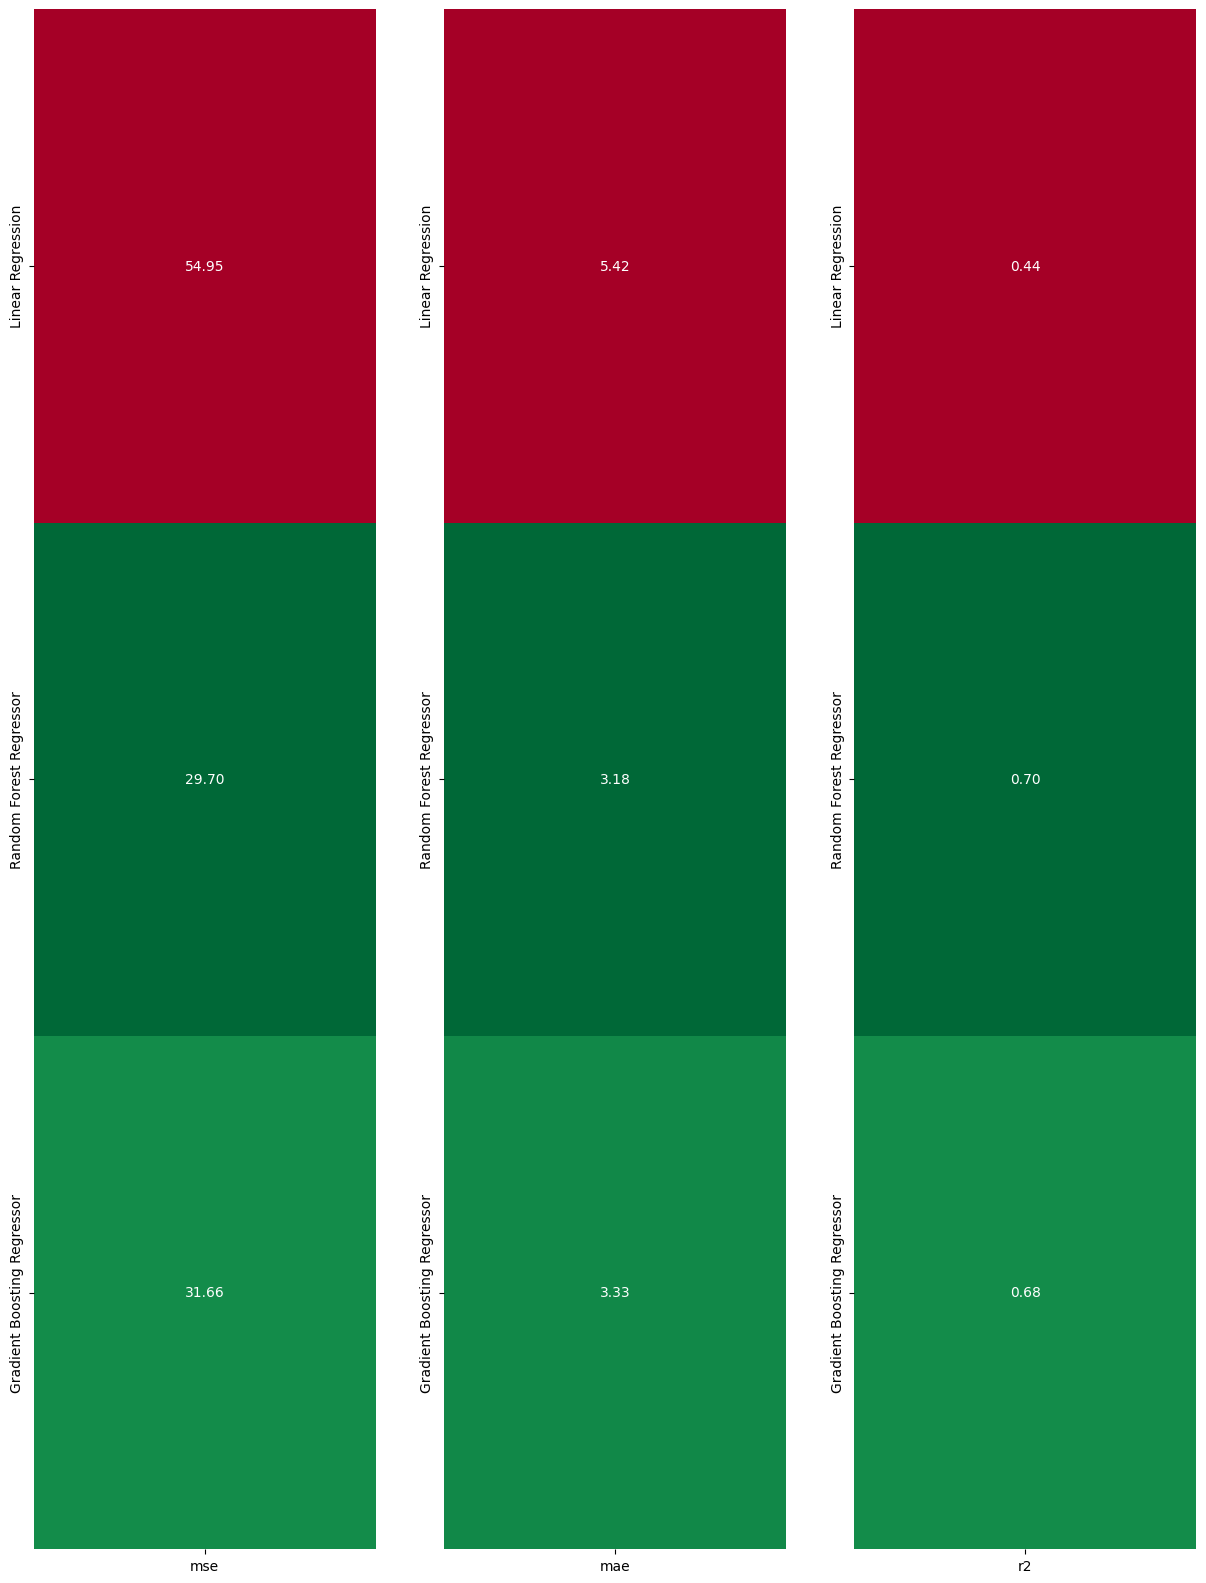

In [440]:
fig, ax= plt.subplots(ncols=3,figsize=(15,20))

sns.heatmap(scores[['mse']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[0],cbar=False)
sns.heatmap(scores[['mae']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[1],cbar=False)
sns.heatmap(scores[['r2']],annot=True,fmt='.2f',cmap='RdYlGn',ax=ax[2],cbar=False)

In [441]:
for i in range(10):
    print(f"LR: {y_pred_lr[i]}, RF: {y_pred_rf[i]}, GBR: {y_pred_gbr[i]}, Real: {y_test.iloc[i]}")

LR: 8.939320733362058, RF: 5.4479428799999985, GBR: 6.990675949842552, Real: 6.2354
LR: 2.392191280778574, RF: 1.486597178, GBR: 1.8296241462655465, Real: 1.853858
LR: 12.412690888532769, RF: 24.89765630999999, GBR: 29.560772165920078, Real: 29.1599
LR: -2.1301660972106378, RF: 0.863659376, GBR: -2.639168271237744, Real: 0.9628921
LR: 4.397327104701292, RF: 2.026681276000002, GBR: 2.5378408102845977, Real: 1.890131
LR: 7.121521499804487, RF: 5.337465081999998, GBR: 4.683577922900362, Real: 1.123462
LR: 7.266211275006818, RF: 7.632047289, GBR: 7.6090851596754545, Real: 7.286301
LR: 7.8694314201278335, RF: 10.801754579999988, GBR: 11.003637483047687, Real: 12.28552
LR: 0.6658148482070327, RF: 4.8476428200000035, GBR: 4.140739547888241, Real: 2.134825
LR: 2.649819139340848, RF: 1.5414726620000019, GBR: 1.4256029666746455, Real: 1.892717


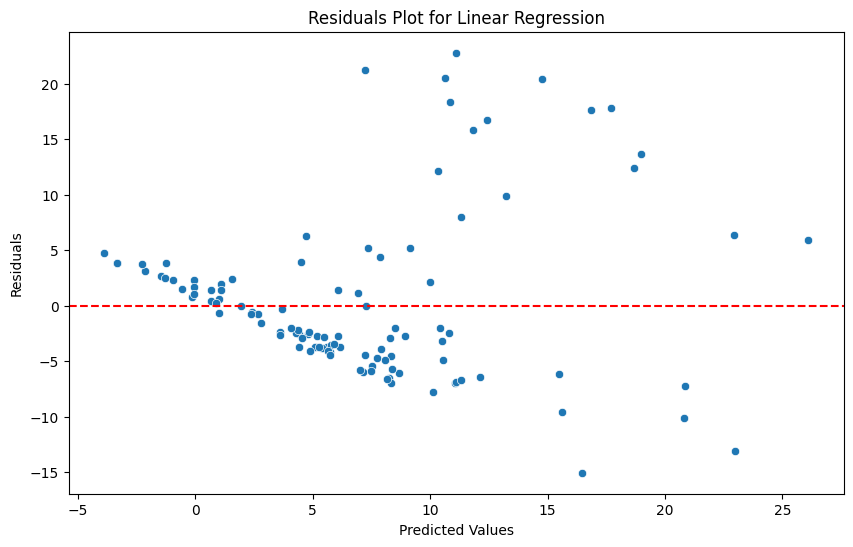

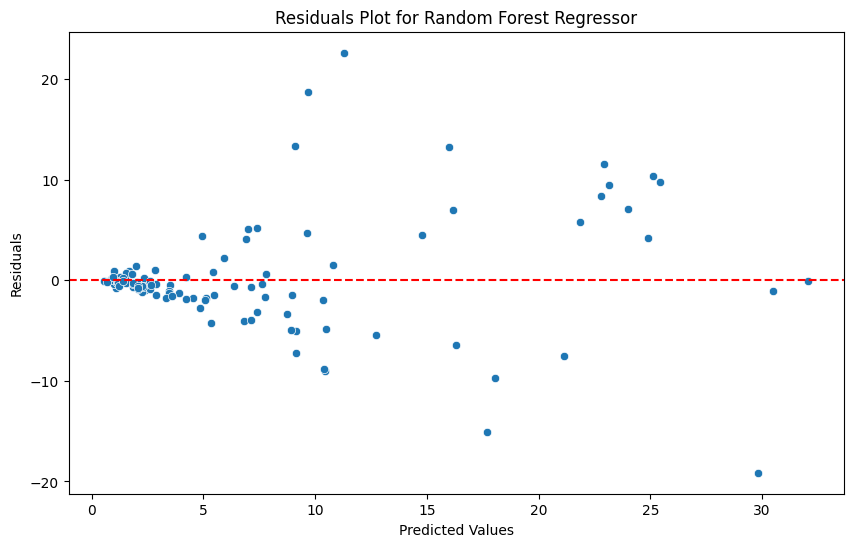

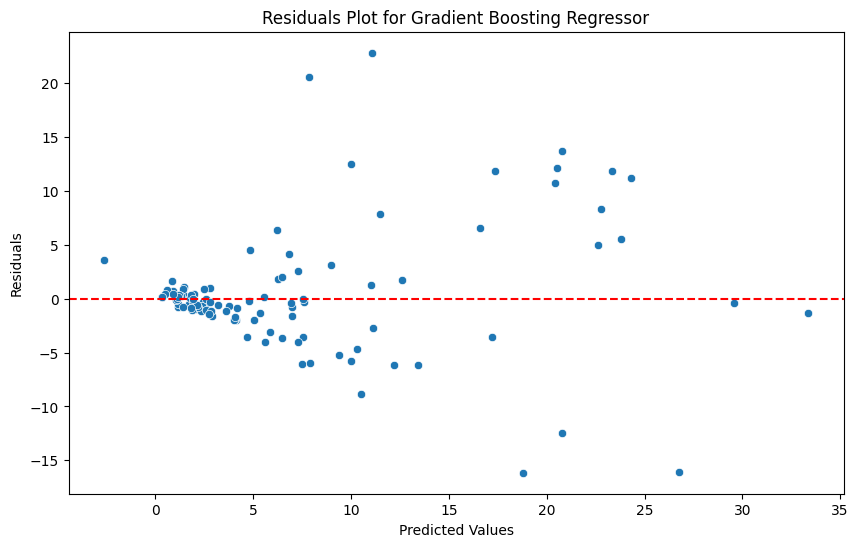

In [442]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for {model_name}')
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")
plot_residuals(y_test, y_pred_rf, "Random Forest Regressor")
plot_residuals(y_test, y_pred_gbr, "Gradient Boosting Regressor")

# Optimizing Models

In [443]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from itertools import product
from sklearn.metrics import r2_score

def best_linear_fit(x_train, y_train, x_test, y_test) -> tuple[object, dict]:
    '''Tests different parameters for LinearRegression, Ridge and Lasso and returns the best model, its parameters and the score on the training set'''
    best_params = {}
    best_score = 0
    best_model = None
    
    # Define the hyperparameter grid
    degrees = [1, 2, 3]  # Degree of polynomial features
    alphas = [0.1, 1, 10]  # Regularization strengths for Ridge and Lasso
    models = ['linear']
    
    for degree, alpha, model_type in product(degrees, alphas, models):
        if model_type == 'linear':
            model = Pipeline([
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                ('linear', LinearRegression())
            ])
            model_name = 'Linear Regression'
        elif model_type == 'ridge':
            model = Pipeline([
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                ('ridge', Ridge(alpha=alpha))
            ])
            model_name = 'Ridge Regression'
        elif model_type == 'lasso':
            model = Pipeline([
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                ('lasso', Lasso(alpha=alpha))
            ])
            model_name = 'Lasso Regression'
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test, y_pred)
        
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {
                'model': model_name,
                'degree': degree,
                'alpha': alpha if model_type in ['ridge', 'lasso'] else None
            }
    
    return best_model, best_params

# Find the best Linear Regression model
best_model, best_params = best_linear_fit(X_train_scaled, y_train, X_test_scaled, y_test)
print(best_params)

{'model': 'Linear Regression', 'degree': 2, 'alpha': None}


In [444]:
def best_forest_fit(x_train, y_train, x_test,y_test) -> tuple[RandomForestRegressor,dict]:
    '''Tests different parameters for RandomForestRegressor and returns the best model, its parameters and the score on the training set'''
    best_params = {}
    best_score = 0
    best_model = None
    for n_estimators, min_samples_split, min_samples_leaf,max_features in product([5,10,25,50],[5,10,15],[1,3,5],[0.2,'sqrt','log2',1]):
        model = RandomForestRegressor(n_jobs=1,n_estimators=n_estimators,max_depth=None,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,random_state=42)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test,y_pred)
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {'n_estimators':n_estimators,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'max_features':max_features}
    return best_model, best_params

rf, forest_params = best_forest_fit(X_train, y_train, X_test, y_test)
print(forest_params)

{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.2}


In [445]:
def best_gradient_boosting_fit(x_train, y_train, x_test, y_test) -> tuple[GradientBoostingRegressor, dict]:
    '''Tests different parameters for Gradient Boosting Regressor and returns the best model, its parameters'''
    best_params = {}
    best_score = 0
    best_model = None
    for n_estimators, min_samples_split, min_samples_leaf, max_features, learning_rate in product([125,150,200,300],[2,5,10],[1,3,5],[0.2,'sqrt','log2',1],[0.05,0.075,0.1,0.15]):
        model = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,learning_rate=learning_rate,random_state=42)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test,y_pred)
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {'n_estimators':n_estimators,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'max_features':max_features,'learning_rate':learning_rate}
    return best_model, best_params

gbr, gradient_params = best_gradient_boosting_fit(X_train, y_train, X_test, y_test)
print(gradient_params)

{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.2, 'learning_rate': 0.15}


In [446]:
lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.15, max_features=0.2,
                          min_samples_split=5, n_estimators=150,
                          random_state=42)

In [447]:
y_pred_lr = lr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)

def evaluate_model(y_true, y_pred, model_name) -> dict[str, float]:
    mse: float = mean_squared_error(y_true, y_pred)
    mae: float = mean_absolute_error(y_true, y_pred)
    r2: float  = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}")
    
    return {"mse": mse, "mae": mae, "r2": r2}

lr_scores: dict[str, float] = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rf_scores: dict[str, float] = evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
gbr_scores: dict[str, float] = evaluate_model(y_test, y_pred_gbr, "Gradient Boosting Regressor")

scores = pd.DataFrame([lr_scores, rf_scores, gbr_scores], index=["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor"])

Linear Regression - MSE: 54.9470391581317, MAE: 5.416832807056178, R2: 0.43753363699797543
Random Forest Regressor - MSE: 31.411707328428157, MAE: 3.4522822274973017, R2: 0.6784534881696113
Gradient Boosting Regressor - MSE: 29.19448128988118, MAE: 3.3229716397908637, R2: 0.7011501627304706


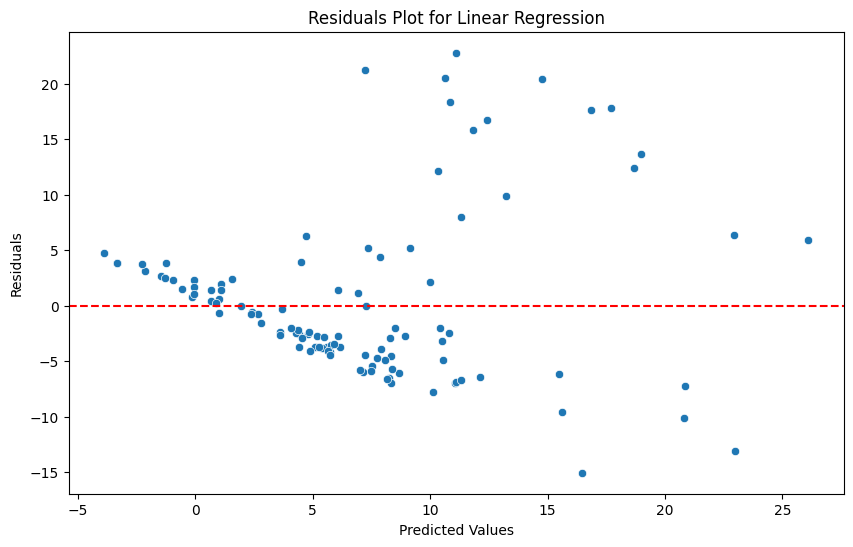

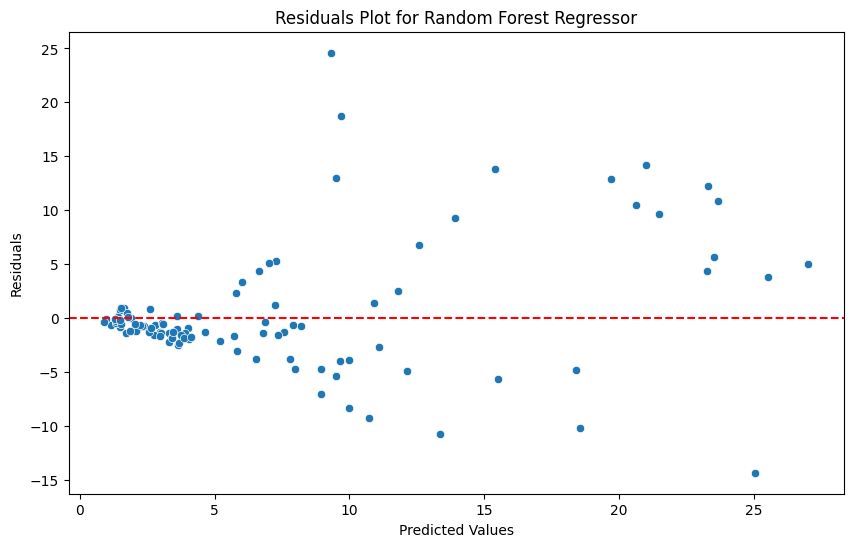

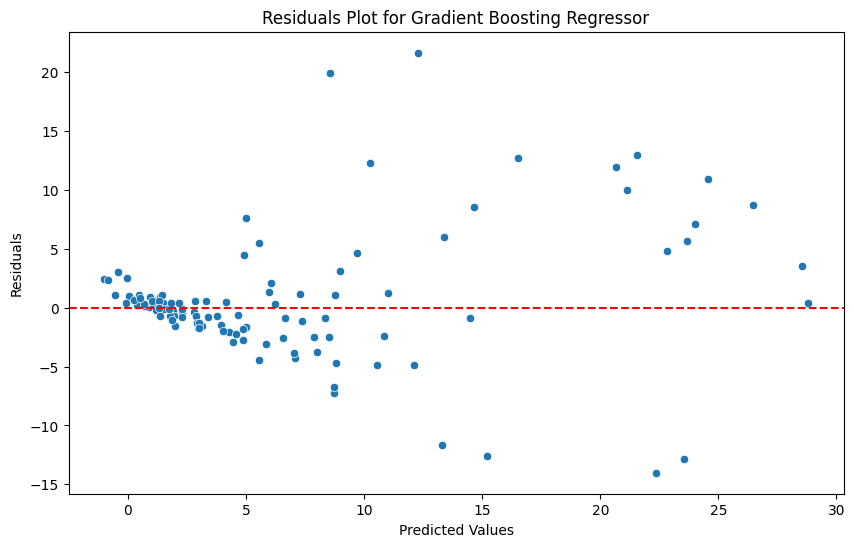

In [448]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for {model_name}')
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")
plot_residuals(y_test, y_pred_rf, "Random Forest Regressor")
plot_residuals(y_test, y_pred_gbr, "Gradient Boosting Regressor")

It is clear, that the models' accuracy decreases, when the predicted values are higher. This suggests heteroscedasticity, and can be improved with transforming data.

# Lowering heteroscedasticity

Transformed Random Forest Regressor - MSE: 37.70207193036662, MAE: 3.452026426754458, R2: 0.6140620568237534


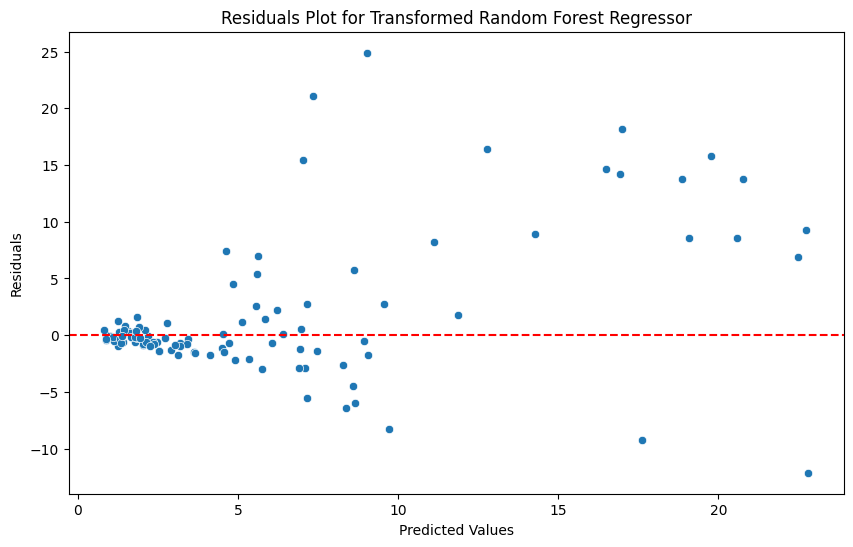

Transformed Gradient Boosting Regressor - MSE: 28.400640255693475, MAE: 3.101394012860437, R2: 0.709276330876061


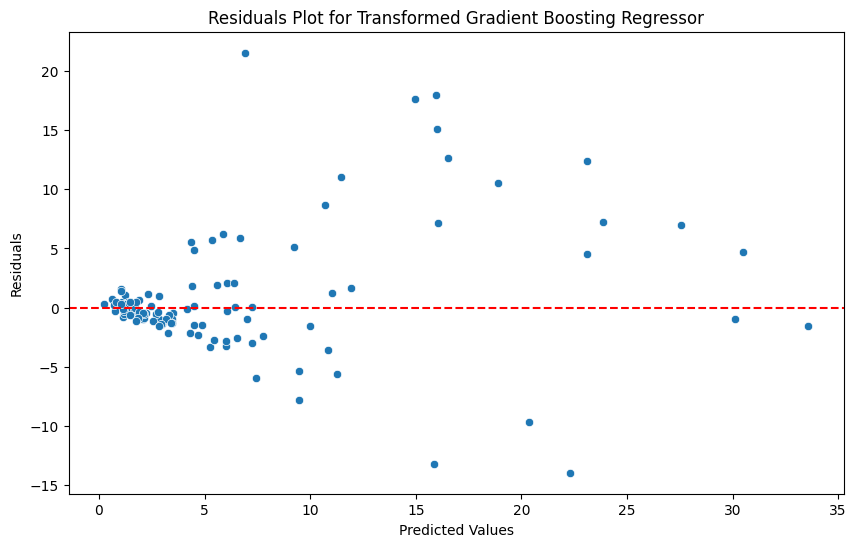

In [449]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

gbr.fit(X_train, y_train_log)
y_pred_log_gbr = gbr.predict(X_test)
y_pred_gbr = np.expm1(y_pred_log_gbr)

rf.fit(X_train, y_train_log)
y_pred_log_rf = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)

evaluate_model(y_test, y_pred_rf, "Transformed Random Forest Regressor")
plot_residuals(y_test, y_pred_rf, "Transformed Random Forest Regressor")

evaluate_model(y_test, y_pred_gbr, "Transformed Gradient Boosting Regressor")
plot_residuals(y_test, y_pred_gbr, "Transformed Gradient Boosting Regressor")

Applying a logarithmic transformation to data slightly improved the MSE and MAE values for Gradient Boosting Regressor. R2 score slightly dropped